# Import Required Libraries
Import necessary Julia packages including CSV, DataFrames, DIVAnd, and plotting libraries.

In [1]:
# Import required packages
using CSV, DataFrames, DIVAnd, Statistics, Plots, Interpolations

# Load and Examine Data Files
Load the test_transect_bathy.csv and test_hydrography.csv files and examine their structure and contents.

In [2]:
# Load the CSV files
bathy_df = CSV.read("../data/test_transect_bathy.csv", DataFrame)
hydro_df = CSV.read("../data/test_hydrography.csv", DataFrame)

# CONVERT ALL DISTANCES TO METERS AT THE START
bathy_df.Distance = bathy_df.Distance * 1000  # Convert km to m
hydro_df.Distance = hydro_df.Distance * 1000  # Convert km to m

println("Data loaded and distances converted to meters")
println("Distance range (bathy): ", extrema(bathy_df.Distance), " meters")
println("Distance range (hydro): ", extrema(hydro_df.Distance), " meters")

# Display basic info about the datasets
println("Bathymetry data shape: ", size(bathy_df))
println("Hydrography data shape: ", size(hydro_df))
println("\nBathymetry columns: ", names(bathy_df))
println("Hydrography columns: ", names(hydro_df))

Data loaded and distances converted to meters
Distance range (bathy): (0.0, 200096.97017423515) meters
Distance range (hydro): (0.0, 200096.97017423515) meters
Bathymetry data shape: (2002, 5)
Hydrography data shape: (2105, 15)

Bathymetry columns: ["TransectPoint", "Distance", "Longitude", "Latitude", "BottomDepth"]
Hydrography columns: ["Station", "Filename", "FilePath", "Depth", "Pressure", "Temperature", "Salinity", "Sigma_t", "Latitude", "Longitude", "Datetime", "Cruise", "Line", "Distance", "OffsetDistance_km"]


# Data Preprocessing and Validation
Clean and validate the data, handle missing values, and ensure proper data types for the interpolation process.

In [3]:
# Remove missing temperature values
valid_data = dropmissing(hydro_df, :Temperature)

# Extract coordinates and values (ALL IN METERS)
obs_x = valid_data.Distance  # Distance in meters
obs_y = valid_data.Depth       # Depth in meters
obs_temp = valid_data.Temperature

println("Valid observations: ", length(obs_temp))
println("Distance range: ", extrema(obs_x), " meters")
println("Depth range: ", extrema(obs_y), " meters")
println("Temperature range: ", extrema(obs_temp))

Valid observations: 2105
Distance range: (0.0, 200096.97017423515) meters
Depth range: (1.4884320562229758, 300.98667342391855) meters
Temperature range: (7.401, 16.1303)


In [4]:
# Calculate typical distance between stations
station_distances = []
unique_stations = unique(obs_x)
sort!(unique_stations)

for i in 2:length(unique_stations)
    push!(station_distances, unique_stations[i] - unique_stations[i-1])
end

typical_station_spacing = median(station_distances)
println("Typical station spacing: ", typical_station_spacing/1000, " km")


Typical station spacing: 40.299389795210764 km


# Create Interpolation Grid
Generate a 2D grid using distance from transect data as x-axis and depth as y-axis with 5m vertical resolution, respecting bottom depth constraints.

In [5]:
# Define grid resolutions
horizontal_res = 1e2  # 100 m horizontal resolution
vertical_res = 1      # 5 m vertical resolution

# Calculate proper grid dimensions
distance_extent = maximum(obs_x) - minimum(obs_x)
depth_extent = maximum(bathy_df.BottomDepth)

n_horizontal = Int(ceil(distance_extent / horizontal_res))
n_vertical = Int(ceil(depth_extent / vertical_res))

# Create regular grid (ALL IN METERS)
x_regular = range(minimum(obs_x), maximum(obs_x), length=n_horizontal)
y_regular = range(0, depth_extent, length=n_vertical)

println("Grid dimensions: ", n_horizontal, " x ", n_vertical)

Grid dimensions: 2001 x 1381


# Prepare Data for DIVAnd
Extract temperature observations with their corresponding distance and depth coordinates, and format them for DIVAnd input.

In [6]:
# Scale factors (inverse of grid resolution)
pm = ones(length(x_regular), length(y_regular)) / horizontal_res
pn = ones(length(x_regular), length(y_regular)) / vertical_res
pmn = (pm, pn)

# Coordinate grids
X_grid = [x for x in x_regular, y in y_regular]
Y_grid = [y for x in x_regular, y in y_regular]
xi = (X_grid, Y_grid)

# Mask
mask = trues(length(x_regular), length(y_regular))

# Apply bathymetry constraint - mask out points below seafloor
for i in 1:length(x_regular)
    # Find corresponding bathymetry depth for this distance
    bathy_depth = LinearInterpolation(bathy_df.Distance, bathy_df.BottomDepth, extrapolation_bc=Flat())(x_regular[i])
    
    # Mask out all depths below seafloor
    for j in 1:length(y_regular)
        if y_regular[j] > bathy_depth
            mask[i, j] = false
        end
    end
end

# Add constraints to keep temperatures within observed range
temp_min, temp_max = extrema(obs_temp)
println("Observed temperature range: ", (temp_min, temp_max))

Observed temperature range: (7.401, 16.1303)


# Configure DIVAnd Parameters
Set up DIVAnd parameters including correlation lengths, error variances, and boundary conditions for the interpolation.

In [154]:
# Try MUCH larger correlation lengths - span the entire domain
domain_x = maximum(x_regular) - minimum(x_regular)
domain_y = maximum(y_regular) - minimum(y_regular)
# domain_y = maximum(obs_y) - minimum(obs_y)

# Scale factors
x_scale = 3.0
y_scale = 0.005

# Correlation lengths (IN METERS)
# len_x = typical_station_spacing * 2.5  # % of domain width
# len_y = domain_y * 0.015   # % of domain height
# len_x = typical_station_spacing * x_scale
# len_y = domain_y * y_scale
len_y = 55.56387
len_x = 64869.82877
len = (len_x, len_y)

println("Domain size: ", domain_x, " x ", domain_y, " meters")
println("Correlation lengths: ", len_x, " x ", len_y, " meters")

# Much lower error variance - force it to interpolate
# epsilon2 = 0.05
epsilon2 = 0.08975597192733631

# Add proper boundary conditions and constraints
# Set up advection constraint to enforce horizontal coherence
velocity = (zeros(size(X_grid)), zeros(size(Y_grid)))  # No advection

# Try adding a background field
background_temp = mean(obs_temp)
temp_anomaly = obs_temp .- background_temp

# Add temperature constraints
constraints = ()  # You may need to add explicit min/max constraints here

Domain size: 200096.97017423515 x 1380.7282421983123 meters
Correlation lengths: 64869.82877 x 55.56387 meters


()

# Perform Temperature Interpolation
Execute the DIVAnd interpolation to estimate temperature values across the entire grid.

In [155]:
# Observation coordinates
x_obs = (obs_x, obs_y)

# Run with anomalies
temp_field_anom, s = DIVAndrun(mask, pmn, xi, x_obs, temp_anomaly, len, epsilon2, velocity=velocity)

# Add background back
temp_field = temp_field_anom .+ background_temp

# Clamp to observed range
# temp_min, temp_max = extrema(obs_temp)
# temp_field = clamp.(temp_field, temp_min, temp_max)

println("New interpolation completed")
println("Temperature range: ", extrema(temp_field[mask]))

New interpolation completed
Temperature range: (5.546373697825975, 16.90031940220365)


# Visualize Results
Create plots and visualizations of the interpolated temperature field, including contour plots and cross-sections.

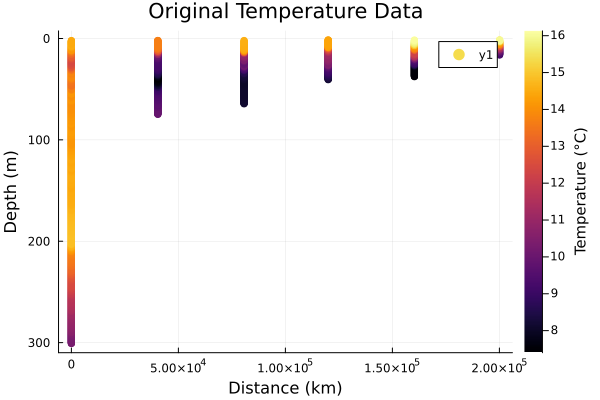

In [ ]:
# Visualize original data
scatter(obs_x, obs_y, zcolor=obs_temp, ylabel="Depth (m)", xlabel="Distance (km)", 
        title="Original Temperature Data", colorbar_title="Temperature (°C)",
        markerstrokewidth=0)
yflip!(true)

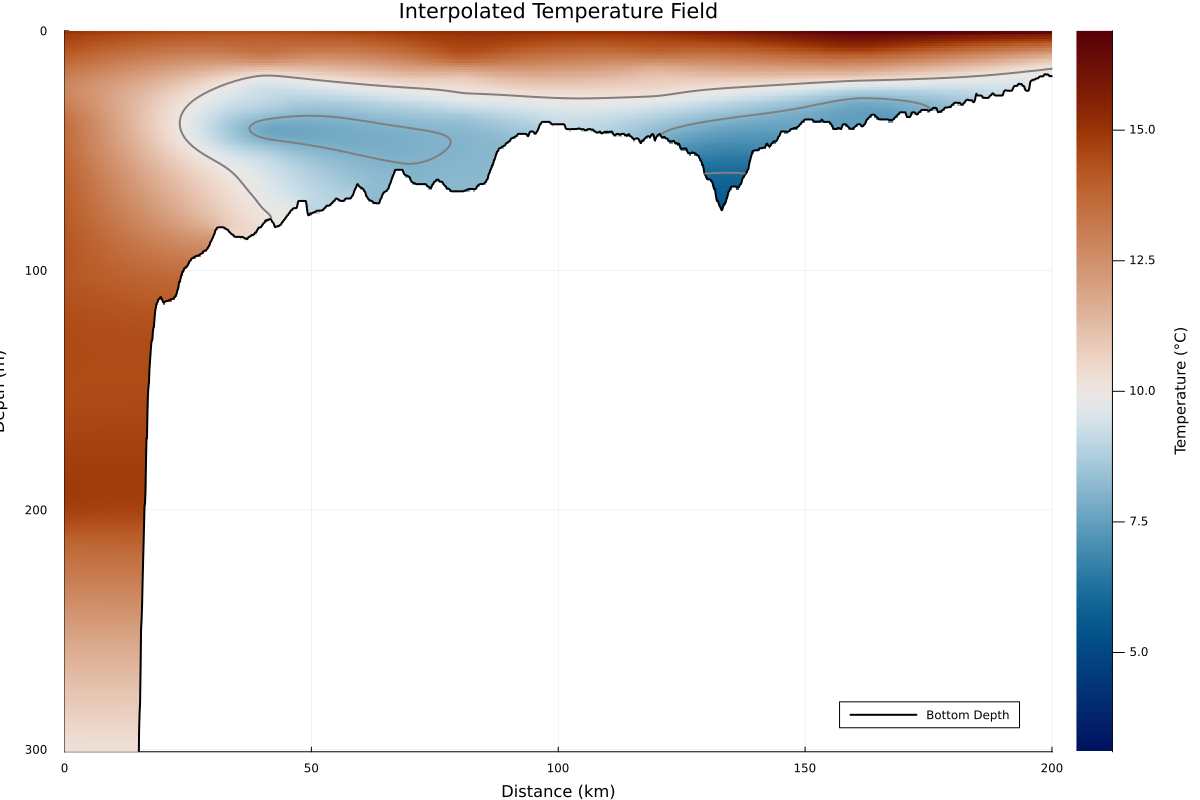

In [ ]:
using Measures

# Set max depth
max_depth = maximum(obs_y)

# Find which y indices correspond to 0-{max_depth}
depth_mask = y_regular .<= max_depth
y_subset = y_regular[depth_mask]
temp_subset = temp_field'[depth_mask, :]

# Update color palette for divergence
MIDPOINT = 10
temp_min, temp_max = extrema(filter(!isnan, temp_field))
temp_range = max(abs(temp_min - MIDPOINT), abs(temp_max - MIDPOINT))
clim_min = MIDPOINT - temp_range
clim_max = MIDPOINT + temp_range

# Plot interpolated field
heatmap(
        collect(x_regular) * 1e-3, 
        # collect(y_regular), 
        collect(y_subset),
        # temp_field', 
        color=:vik,
        temp_subset,        
        xlabel="Distance (km)", ylabel="Depth (m)", 
        title="Interpolated Temperature Field", 
        colorbar_title="Temperature (°C)",
        xlims=(minimum(x_regular * 1e-3), maximum(x_regular * 1e-3)),
        clims=(clim_min, clim_max),
        size=(1200, 800),
        margin=5Plots.mm
      )
yflip!(true)

# # Add bathymetry
plot!(bathy_df.Distance * 1e-3, bathy_df.BottomDepth, color=:black, linewidth=2, 
      label="Bottom Depth", yflip=true, ylim=(0, max_depth),
      legend=:bottomright,)

# Add contour lines at specific isotherms
contour!(collect(x_regular) * 1e-3, collect(y_regular), temp_field', 
         levels=[6, 8, 10], 
         color=:gray50, 
         colorbar_entry=false,
         linewidth=2)